In [18]:
## CONV LSTM Transfer Learning on Different DataSet

import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

import os
tf.random.set_seed(42)


sys.path.insert(0, '../../src')
from utils import df_to_xarray,read_xarray, get_point_prediction, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp, inverse_scale_frame

In [45]:
tf.keras.backend.clear_session()

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## CESM Data

In [46]:
dir_name="../../data/data1"
val_dir_name="../../data/data2"

data,pco2 = preprocess_images_nfp(dir_name)
data_socat, pco2_socat = preprocess_images_nfp(dir_name, socat = True)

val_data,val_pco2 = preprocess_images_nfp(val_dir_name,"035")
val_data_socat,val_pco2_socat = preprocess_images_nfp(val_dir_name,"035",socat=True)

X_index=np.lib.stride_tricks.sliding_window_view(range(421),3) 

y=np.expand_dims(val_pco2_socat[X_index][1:],axis=4)
X=val_data[X_index][:-1]

print(X.shape, y.shape)

INPUT_SHAPE = X.shape[0]

(418, 3, 180, 360, 6) (418, 3, 180, 360, 1)


In [47]:
base_model = tf.keras.models.load_model('../../models/base_CNN_LSTM_new.h5', custom_objects={'custom_rmse':custom_rmse})

for layer in base_model.layers[:-2]:
    layer.trainable = False
    
base_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=1e-4),
)
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 3, 180, 360, 32)   121728    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 3, 180, 360, 32)   73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 3, 180, 360, 32)   8320      
_________________________________________________________________
conv3d (Conv3D)              (None, 3, 180, 360, 1)    865       
Total params: 205,025
Trainable params: 9,185
Non-trainable params: 195,840
______________________________________________

In [48]:

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
callbacks=[early_stopings]

epochs = 10
batch_size = 16


history = base_model.fit(
    X,
    y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X,y),
    callbacks=callbacks,
)


Epoch 1/10
19/27 [====================>.........] - ETA: 5s - loss: 61.6733

KeyboardInterrupt: 

In [15]:
pred = base_model.predict(X,verbose=True)


14/14 [==============================] - 8s 473ms/step


In [23]:
chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(val_dir_name,num="035")

y_true,y_pred = inverse_scale_frame(pred,pco2t2.pCO2.data)


y_pred_socat = np.copy(y_pred)
y_true_socat=np.expand_dims(pco2t2.pCO2_socat.data[X_index][1:],axis=4)
y_true_socat = np.nan_to_num(y_true_socat)
y_pred_socat[y_true_socat==0]=0.0

In [24]:
print("Full RMSE score:")
a=custom_rmse(y_pred[:,:1],y_true[:,:1])
print(a.numpy())

print("SOCAT RMSE score:")
b=custom_rmse(y_pred_socat[:,:1],y_true_socat[:,:1])
print(b.numpy())



Full RMSE score:
5.704758296676763
SOCAT RMSE score:
6.3634920134504895


In [28]:
rmses = []
rmses_socat = []

for i in range(418):    
    rmse =custom_rmse(y_pred[i],y_true[i]).numpy()
    rmses.append(rmse)
    rmse =custom_rmse(y_pred_socat[i],y_true_socat[i]).numpy()
    rmses_socat.append(rmse)
    

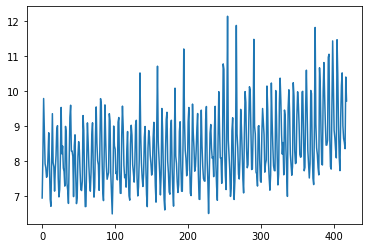

In [29]:
plt.plot(rmses)

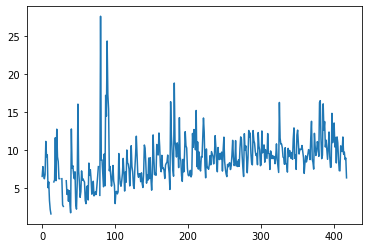

In [30]:
plt.plot(rmses_socat)

## MPI

In [32]:
mpi_dir_name = "../../data/mpi_001"


data,pco2 = preprocess_images_nfp(mpi_dir_name,mpi=True)
data_socat, pco2_socat = preprocess_images_nfp(mpi_dir_name, socat = True,mpi=True)


X_index = np.lib.stride_tricks.sliding_window_view(range(421),3) 

y = np.expand_dims(pco2[X_index][1:],axis=4)
X = data[X_index][:-1]

print(X.shape, y.shape)

INPUT_SHAPE = X.shape[0]

for layer in base_model.layers[:-4]:
    layer.trainable = False
    
base_model.summary()

(418, 3, 180, 360, 6) (418, 3, 180, 360, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 3, 180, 360, 32)   121728    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 3, 180, 360, 32)   73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 3, 180, 360, 32)   8320      
_________________________________________________________________
conv3d (Conv3D)              (None, 3, 180, 360, 1)    865       
Total params: 205,025
Trainable params: 9,185
Non-trainable params: 195,840
__

In [34]:
base_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=1e-4),
)

model_path="../../models/transfer_mpi_convlstm.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 10
batch_size = 16


history = base_model.fit(
    X,
    y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X,y),
    callbacks=callbacks,
)

Epoch 1/10
27/27 [==============================] - 30s 997ms/step - loss: 10.3235 - val_loss: 6.6818
Epoch 2/10
27/27 [==============================] - 24s 912ms/step - loss: 6.6052 - val_loss: 6.3828
Epoch 3/10
27/27 [==============================] - 24s 916ms/step - loss: 6.2849 - val_loss: 6.1195
Epoch 4/10
27/27 [==============================] - 24s 915ms/step - loss: 6.0201 - val_loss: 5.9130
Epoch 5/10
27/27 [==============================] - 25s 916ms/step - loss: 5.9701 - val_loss: 5.7539
Epoch 6/10
27/27 [==============================] - 25s 919ms/step - loss: 5.7170 - val_loss: 5.6320
Epoch 7/10
27/27 [==============================] - 25s 918ms/step - loss: 5.6236 - val_loss: 5.5356
Epoch 8/10
27/27 [==============================] - 25s 917ms/step - loss: 5.5437 - val_loss: 5.4608
Epoch 9/10
27/27 [==============================] - 25s 917ms/step - loss: 5.5663 - val_loss: 5.4020
Epoch 10/10
27/27 [==============================] - 24s 915ms/step - loss: 5.3915 - val_l

In [36]:
best_model = tf.keras.models.load_model('../../models/transfer_mpi_convlstm.h5', custom_objects={'custom_rmse':custom_rmse})

pred = best_model.predict(X,verbose=True)

14/14 [==============================] - 7s 498ms/step


In [37]:
chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(mpi_dir_name, mpi = True)

y_true,y_pred = inverse_scale_frame(pred,pco2t2.pCO2.data)


y_pred_socat = np.copy(y_pred)
y_true_socat=np.expand_dims(pco2t2.pCO2_socat.data[X_index][1:],axis=4)
y_true_socat = np.nan_to_num(y_true_socat)
y_pred_socat[y_true_socat==0]=0.0


In [38]:
print("Full RMSE score:")
a=custom_rmse(y_pred[:,:1],y_true[:,:1])
print(a.numpy())

print("SOCAT RMSE score:")
b=custom_rmse(y_pred_socat[:,:1],y_true_socat[:,:1])
print(b.numpy())





Full RMSE score:
13.132568
SOCAT RMSE score:
12.955608977738484


In [40]:
rmses = []
rmses_socat = []

for i in range(418):    
    rmse =custom_rmse(y_pred[i],y_true[i]).numpy()
    rmses.append(rmse)
    rmse =custom_rmse(y_pred_socat[i],y_true_socat[i]).numpy()
    rmses_socat.append(rmse)
    

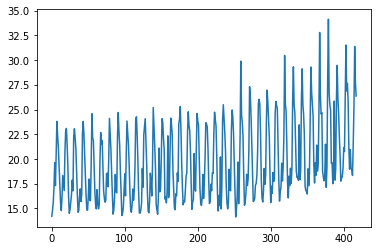

In [41]:
plt.plot(rmses)

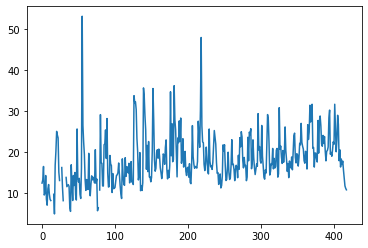

In [42]:
plt.plot(rmses_socat)

(array([2.0000000e+00, 4.0000000e+00, 2.1000000e+01, 7.3000000e+01,
        2.9200000e+02, 9.9200000e+02, 2.8230000e+03, 8.8030000e+03,
        3.1525000e+04, 9.4684000e+04, 2.5932800e+05, 1.0901060e+06,
        4.8512590e+06, 1.9191892e+07, 1.2418410e+06, 2.1206800e+05,
        5.9840000e+04, 2.2171000e+04, 9.3160000e+03, 4.3730000e+03,
        2.2610000e+03, 1.1580000e+03, 6.1800000e+02, 3.7100000e+02,
        1.7700000e+02, 1.0100000e+02, 5.4000000e+01, 6.6000000e+01,
        4.5000000e+01, 5.4000000e+01, 2.5000000e+01, 1.8000000e+01,
        1.5000000e+01, 1.0000000e+01, 5.0000000e+00, 4.0000000e+00,
        2.0000000e+00, 2.0000000e+00, 0.0000000e+00, 1.0000000e+00]),
 array([-187.77954  , -173.52153  , -159.26352  , -145.00551  ,
        -130.7475   , -116.489494 , -102.23148  ,  -87.97347  ,
         -73.71547  ,  -59.45746  ,  -45.199448 ,  -30.941439 ,
         -16.68343  ,   -2.4254196,   11.83259  ,   26.0906   ,
          40.34861  ,   54.606617 ,   68.864624 ,   83.122635 

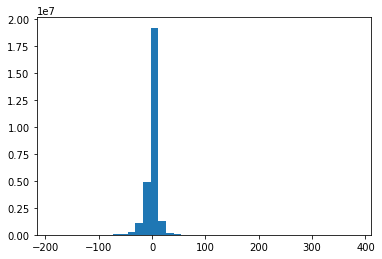

In [43]:
plt.hist(np.array(y_true[:,:1]-y_pred[:,:1]).flatten(),bins=40)

(array([1.0000e+00, 2.0000e+00, 8.0000e+00, 2.0000e+01, 2.3000e+01,
        4.5000e+01, 6.9000e+01, 1.2300e+02, 2.4900e+02, 4.0300e+02,
        6.4100e+02, 1.3200e+03, 2.3180e+03, 6.5620e+03, 1.3834e+04,
        2.5407e+04, 5.9376e+04, 7.7891e+04, 3.3877e+04, 9.7920e+03,
        4.0130e+03, 1.8190e+03, 8.5000e+02, 4.8100e+02, 3.1200e+02,
        1.9300e+02, 9.8000e+01, 7.2000e+01, 3.8000e+01, 2.7000e+01,
        1.0000e+01, 9.0000e+00, 9.0000e+00, 9.0000e+00, 4.0000e+00,
        1.0000e+00, 5.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-123.58288574, -116.35918579, -109.13548584, -101.91178589,
         -94.68808594,  -87.46438599,  -80.24068604,  -73.01698608,
         -65.79328613,  -58.56958618,  -51.34588623,  -44.12218628,
         -36.89848633,  -29.67478638,  -22.45108643,  -15.22738647,
          -8.00368652,   -0.77998657,    6.44371338,   13.66741333,
          20.89111328,   28.11481323,   35.33851318,   42.56221313,
          49.78591309,   57.00961304,   64.233

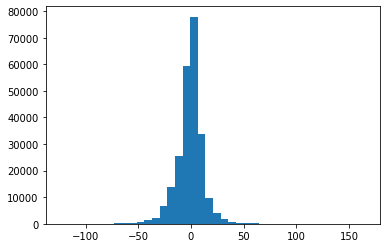

In [44]:
res_socat = np.array(y_true_socat[:,:1]-y_pred_socat[:,:1]).flatten()
res_socat_nonzero = res_socat[res_socat!=0]
plt.hist(res_socat_nonzero,bins=40)

## Canadian Model

In [107]:
can_dir_name = "../../data/can_001"

data,pco2 = preprocess_images(can_dir_name,can=True)
data_socat, pco2_socat = preprocess_images(can_dir_name, socat = True,can=True)

for layer in base_model.layers[:-4]:
    layer.trainable = False
    
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 64)      8064      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 128)      204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 128)      409728    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 180, 360, 128)     0

In [108]:
base_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=1e-3),
)

model_path="../../models/transfer_can_cnn.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 100
batch_size = 16


history = base_model.fit(
    data,
    pco2,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(data, pco2),
    callbacks=callbacks,
)

Epoch 1/100
27/27 [==============================] - 4s 155ms/step - loss: 5.2480 - val_loss: 3.7693
Epoch 2/100
27/27 [==============================] - 8s 201ms/step - loss: 3.7498 - val_loss: 3.5560
Epoch 3/100
27/27 [==============================] - 3s 129ms/step - loss: 3.6420 - val_loss: 3.4898
Epoch 4/100
27/27 [==============================] - 3s 129ms/step - loss: 3.5842 - val_loss: 3.4594
Epoch 5/100
27/27 [==============================] - 3s 129ms/step - loss: 3.5309 - val_loss: 3.4565
Epoch 6/100
27/27 [==============================] - 3s 130ms/step - loss: 3.5082 - val_loss: 3.4115
Epoch 7/100
27/27 [==============================] - 3s 129ms/step - loss: 3.4802 - val_loss: 3.4057
Epoch 8/100
27/27 [==============================] - 3s 129ms/step - loss: 3.4856 - val_loss: 3.3730
Epoch 9/100
27/27 [==============================] - 3s 130ms/step - loss: 3.5115 - val_loss: 3.3879
Epoch 10/100
27/27 [==============================] - 3s 130ms/step - loss: 3.4331 - val_lo

In [110]:
best_model = tf.keras.models.load_model('../../models/transfer_can_cnn.h5', custom_objects={'custom_rmse':custom_rmse})

pred = best_model.predict(data,verbose=True)

14/14 [==============================] - 1s 69ms/step


In [111]:
chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(can_dir_name, can = True)

y_true,y_pred = inverse_scale_image(pred,pco2t2.pCO2.data)


y_pred_socat = np.copy(y_pred)
y_true_socat = np.nan_to_num(pco2t2.pCO2_socat.data)
y_pred_socat[y_true_socat==0]=0.0

print("Full RMSE score:")
a=custom_rmse(y_pred,y_true)
print(a.numpy())

print("SOCAT RMSE score:")
b=custom_rmse(y_pred_socat,y_true_socat)
print(b.numpy())


Full RMSE score:
43.299442
SOCAT RMSE score:
46.05307947720219


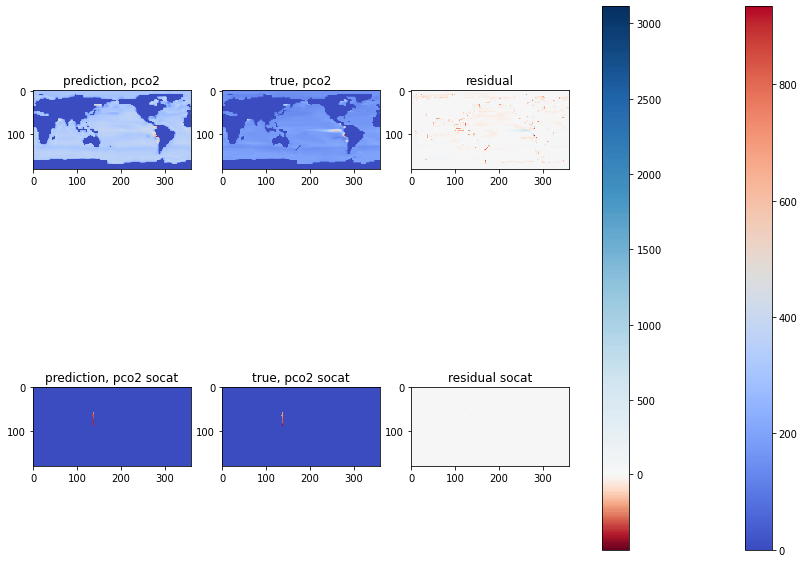

In [116]:
import matplotlib.colors as mcolors

figure, axis = plt.subplots(2, 3,figsize=(15, 10))

d = y_true - y_pred

norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)

img=axis[0][0].imshow(np.flipud(y_pred[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction, pco2")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y_true[0]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true, pco2")

diff=np.flipud(np.squeeze(y_true[0]-y_pred[0]))
img2=axis[0][2].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[0][2].set_title("residual")
plt.colorbar(img2,ax=axis)


img3=axis[1][0].imshow(np.flipud(y_pred_socat[0]),cmap="coolwarm", interpolation="nearest")
axis[1][0].set_title("prediction, pco2 socat")

img4=axis[1][1].imshow(np.flipud(y_true_socat[0]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("true, pco2 socat")

diff=np.flipud(np.squeeze(y_true_socat[0]-y_pred_socat[0]))

img5=axis[1][2].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][2].set_title("residual socat")

plt.show()

In [117]:
rmses = []
rmses_socat = []

for i in range(421):    
    rmse =custom_rmse(y_pred[i],y_true[i]).numpy()
    rmses.append(rmse)
    rmse =custom_rmse(y_pred_socat[i],y_true_socat[i]).numpy()
    rmses_socat.append(rmse)

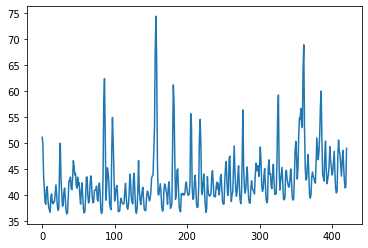

In [118]:
plt.plot(rmses)

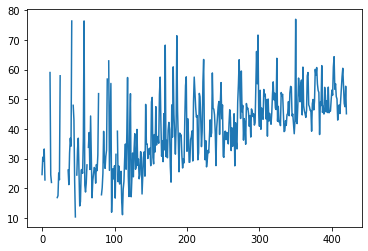

In [119]:
plt.plot(rmses_socat)

(array([2.9100000e+02, 3.3180000e+03, 4.6929000e+04, 1.8674700e+05,
        6.6095400e+05, 2.4943596e+07, 1.3333020e+06, 7.8289000e+04,
        1.4343000e+04, 5.4260000e+03, 2.7210000e+03, 1.6650000e+03,
        1.0340000e+03, 6.6100000e+02, 4.3900000e+02, 2.8200000e+02,
        1.9500000e+02, 1.4200000e+02, 1.0500000e+02, 7.1000000e+01,
        4.3000000e+01, 4.6000000e+01, 4.1000000e+01, 2.8000000e+01,
        2.4000000e+01, 2.2000000e+01, 2.4000000e+01, 6.0000000e+00,
        9.0000000e+00, 8.0000000e+00, 7.0000000e+00, 4.0000000e+00,
        5.0000000e+00, 6.0000000e+00, 6.0000000e+00, 6.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 2.0000000e+00, 2.0000000e+00]),
 array([-495.9901 , -405.7187 , -315.44724, -225.1758 , -134.90436,
         -44.63292,   45.63852,  135.90996,  226.1814 ,  316.45282,
         406.72427,  496.99573,  587.26715,  677.5386 ,  767.81006,
         858.0815 ,  948.3529 , 1038.6244 , 1128.8958 , 1219.1672 ,
        1309.4387 , 1399.7101 , 1489.9816 , 15

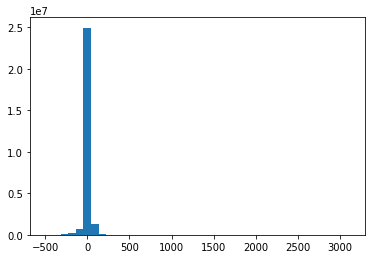

In [120]:
plt.hist(np.array(y_true-y_pred).flatten(),bins=40)

(array([4.20000e+01, 2.99000e+02, 6.64000e+02, 1.84000e+03, 2.73500e+03,
        3.92800e+03, 5.95460e+04, 1.51106e+05, 2.77750e+04, 3.47600e+03,
        7.18000e+02, 1.20000e+02, 6.10000e+01, 3.50000e+01, 1.10000e+01,
        1.20000e+01, 5.00000e+00, 6.00000e+00, 3.00000e+00, 4.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 2.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-377.53885841, -324.78831573, -272.03777304, -219.28723035,
        -166.53668766, -113.78614497,  -61.03560228,   -8.2850596 ,
          44.46548309,   97.21602578,  149.96656847,  202.71711116,
         255.46765385,  308.21819654,  360.96873922,  413.71928191,
         466.4698246 ,  519.22036729,  571.97090998,  624.72145267,
         677.47199535,  730.22253804,  782.97308073,  835.72362342,
      

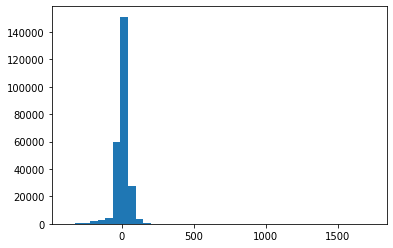

In [121]:
res_socat = np.array(y_true_socat-y_pred_socat).flatten()
res_socat_nonzero = res_socat[res_socat!=0]
plt.hist(res_socat_nonzero,bins=40)